In [1]:
import tensorflow as tf
import os
import json

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, AveragePooling2D, ZeroPadding2D, Add, Conv2D, Flatten, Reshape
from pprint import pprint

from pixor_utils.model_utils import load_model
from models.rangeview_branch import create_range_view_branch
from models.sensor_fusion_net import create_sensor_fusion_net

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2" 

In [3]:
# model = load_model('outputs/contfuse_mlb_test/logs/08-12-05-18/contfuse_mlb_test_epoch_8.json',
#                      'outputs/contfuse_mlb_test/logs/08-12-05-18/contfuse_mlb_test_epoch_8.h5')
# pprint(model.inputs)
# pprint(model.outputs)

# json_file = open('outputs/contfuse_mlb_test/logs/08-12-05-18/contfuse_mlb_test_epoch_8.json', 'r')
# weights_path = 'outputs/contfuse_mlb_test/logs/08-12-05-18/contfuse_mlb_test_epoch_8.h5'
model = create_sensor_fusion_net()
# model.load_weights(weights_path)
# # json_file = open('outputs/mlb_new_rot/mlb_new_rot_epoch_85.json')
# loaded_model_json = json_file.read()
# json_file.close()
# # json.loads(loaded_model_json)
# # pprint(loaded_model_json)
# loaded_model = model_from_json(loaded_model_json)
# # loaded_model.load_weights(weights_path)

Loaded model from disk
rv_high.shape (None, 188, 621, 128)
inputs_dict['mapping_2x'].shape (None, 224, 256, 2)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

rv_mid.shape (None, 94, 311, 192)
inputs_dict['mapping_4x'].shape (None, 112, 128, 2)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just t

In [4]:
# loaded_model

In [4]:
# model = create_sensor_fusion_net()
pprint(model.inputs)
pprint(model.outputs)

[<tf.Tensor 'bev_input:0' shape=(None, 448, 512, 32) dtype=float64>,
 <tf.Tensor 'mapping_2x:0' shape=(None, 224, 256, 2) dtype=int32>,
 <tf.Tensor 'mapping_4x:0' shape=(None, 112, 128, 2) dtype=int32>,
 <tf.Tensor 'mapping_8x:0' shape=(None, 56, 64, 2) dtype=int32>,
 <tf.Tensor 'geo_2x:0' shape=(None, 224, 256, 3) dtype=float64>,
 <tf.Tensor 'geo_4x:0' shape=(None, 112, 128, 3) dtype=float64>,
 <tf.Tensor 'geo_8x:0' shape=(None, 56, 64, 3) dtype=float64>,
 <tf.Tensor 'rgb_img_input:0' shape=(None, 375, 1242, 3) dtype=float64>,
 <tf.Tensor 'depth_map:0' shape=(None, 375, 1242, 1) dtype=float64>,
 <tf.Tensor 'intensity_map:0' shape=(None, 375, 1242, 1) dtype=float64>,
 <tf.Tensor 'height_map:0' shape=(None, 375, 1242, 1) dtype=float64>]
[<tf.Tensor 'obj_map/Sigmoid:0' shape=(None, 112, 128, 1) dtype=float32>,
 <tf.Tensor 'geo_map/BiasAdd:0' shape=(None, 112, 128, 8) dtype=float32>,
 <tf.Tensor 'RV_high_ReLU/Relu:0' shape=(None, 188, 621, 128) dtype=float32>,
 <tf.Tensor 'RV_mid_ReLU/Rel

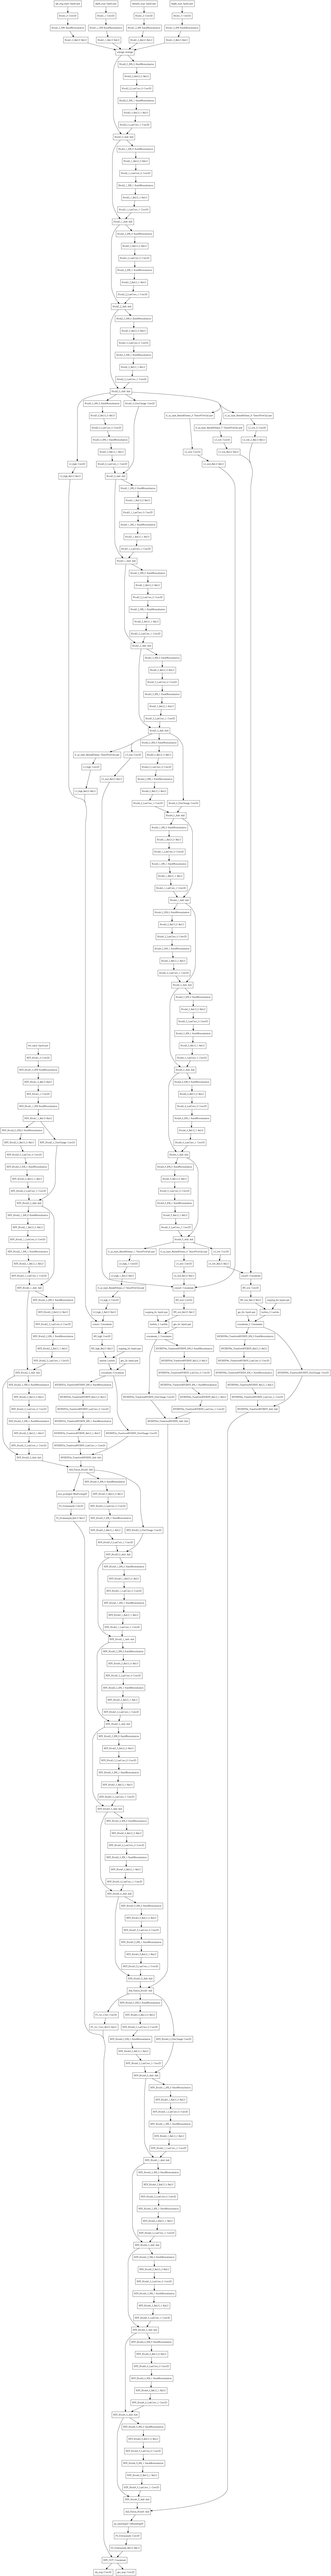

In [7]:
tf.keras.utils.plot_model(
    model, dpi=90, to_file='full_model.png'
)